# 🌍 Projet Incendies — Nettoyage, EDA & Modélisation

Ce projet s’inscrit dans le cadre de l’étude **“Terre, Vent, Feu, Eau, Data”**, avec un objectif clair :  
👉 exploiter les données historiques des incendies en France (BDIFF + référentiel des communes) pour mieux comprendre leurs causes, leur répartition, et tenter de prédire les risques.

---

## 🎯 Objectifs du projet

1. **Exploration des données**  
   - Connexion à une base **SQLite** contenant :
     - Les incendies (`incendies`),  
     - Les communes (`communes`),  
     - Une table enrichie (`incendies_communes`).  
   - Vérification de la structure et du contenu des tables.

2. **Nettoyage & préparation**  
   - Gestion des valeurs **manquantes** (lat/lon, surfaces, causes).  
   - Suppression ou gestion des **doublons**.  
   - Détection et traitement des **outliers** (ex: surfaces négatives ou aberrantes).  
   - Regroupement des **catégories rares** (dans les causes d’incendie).

3. **Analyse exploratoire (EDA)**  
   - Distribution temporelle (par année, saison, mois).  
   - Distribution spatiale (par département, communes).  
   - Analyse des surfaces brûlées et de leurs facteurs.  
   - Visualisations (courbes, histogrammes, camemberts, cartes).

4. **Modélisation (Machine Learning)**  
   - Construction d’une variable cible : **incendie majeur** (ex: surface > 10 ha).  
   - Features candidates : année, département, type de peuplement, cause, météo (si disponible)…  
   - Modèle de base : **Random Forest** pour prédire la probabilité d’un incendie majeur.  
   - Évaluation : matrice de confusion, précision, rappel, F1-score.

---

## 0) Les Imports

In [298]:
# === Imports ===
import sqlite3
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

from rapidfuzz.fuzz import partial_ratio

# === Paramètres généraux ===
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 140)

plt.rcParams['figure.figsize'] = (9,5)

# === Chemins / Tables ===
db_path = "../data/incendies.db"      
table_name = "incendies_communes"           

Path(db_path).exists(), db_path


(True, '../data/incendies.db')

## 1. **Exploration des données** 

In [248]:
# Connexion à la base
con = sqlite3.connect(db_path)

# Nombre de lignes par table + nb de colonnes (approx via PRAGMA)
def table_shape(connection):
    out = []
    
    for t in ['incendies', 'communes', 'incendies_communes']:
        n = pd.read_sql(f"SELECT COUNT(*) AS n FROM {t};", connection).iloc[0,0]
        cols = pd.read_sql(f"PRAGMA table_info({t});", connection)
        out.append({"Table": t, "Linges": n, "Colonnes": len(cols)})
    return pd.DataFrame(out).sort_values("Linges", ascending=False)

table_shapes = table_shape(con)
table_shapes


,Table,Linges,Colonnes
0,incendies,128916,25
2,incendies_communes,128916,18
1,communes,34935,48


> **Note :** Pour voir la taille de chacune de mes table 

### 1. Inspection initiale

In [249]:
sample_rows = 200_000  
try:
    df = pd.read_sql(f"SELECT * FROM {table_name} LIMIT {sample_rows};", con)
except Exception as e:
    print("Erreur de lecture : ", e)
    raise

print("Shape (sample):", df.shape)
df.head(3)


Shape (sample): (128916, 18)


,annee,numero,departement,code_insee,commune_incendie,date_alerte,surface_parcourue_m2,type_peuplement,nature,nb_deces,nb_batiments_totalement_detruits,nb_batiments_partiellement_detruits,commune_ref,lat,lon,population,superficie_km2,densite
0,1978,636,11,11262,Narbonne,1978-01-01 03:20:00,1000,1,,,,,Narbonne,43.165,3.02,56395,175,323.0
1,1978,750,13,13051,Lançon-Provence,1978-01-01 12:51:00,8000,1,,,,,Lançon-Provence,43.576,5.16,9340,69,135.0
2,1978,3779,83,83063,La Garde-Freinet,1978-01-01 16:10:00,15000,4,,,,,La Garde-Freinet,43.323,6.467,1831,77,24.0


### 📝 Tableau des Features

| Colonne                             | Définition / Description |
|-------------------------------------|--------------------------|
| **annee**                           | Année civile de l’incendie (AAAA). |
| **numero**                          | Numéro unique de l’incendie dans l’année. |
| **departement**                     | Code du département où l’incendie a eu lieu. |
| **code_insee**                      | Code INSEE de la commune concernée. |
| **commune_incendie**                | Nom de la commune où l’incendie a démarré. |
| **date_alerte**                     | Date et heure où le départ de feu est signalé au CODIS. |
| **surface_parcourue_m2**            | Surface totale parcourue par le feu (m²), toutes végétations confondues. |
| **type_peuplement**                 | Type de formation végétale principalement touchée : landes/garrigues/maquis, taillis, futaies feuillues, futaies résineuses, futaies mélangées, régénération ou reboisement. |
| **nature**                          | Origine de l’incendie (si connue) : naturelle, accidentelle, malveillance, involontaire (travaux), involontaire (particulier). |
| **nb_deces**                        | Nombre de décès directement liés à l’incendie. |
| **nb_batiments_totalement_detruits**| Nombre de bâtiments détruits (toiture effondrée, structure inutilisable). |
| **nb_batiments_partiellement_detruits** | Nombre de bâtiments endommagés mais partiellement utilisables. |
| **commune_ref**                     | Référence normalisée de la commune (ex. correspondance INSEE). |
| **lat**                             | Latitude de la commune / du centre du feu. |
| **lon**                             | Longitude de la commune / du centre du feu. |
| **population**                      | Population de la commune (données INSEE). |
| **superficie_km2**                  | Superficie totale de la commune en km². |
| **densite**                         | Densité de population (hab./km²). |


In [250]:
# La table enrichie contient 128916 lignes et 18 colonnes.
df.shape

(128916, 18)

In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128916 entries, 0 to 128915
Data columns (total 18 columns):
 #   Column                               Non-Null Count   Dtype 
---  ------                               --------------   ----- 
 0   annee                                128916 non-null  object
 1   numero                               128916 non-null  object
 2   departement                          128916 non-null  object
 3   code_insee                           128916 non-null  object
 4   commune_incendie                     128916 non-null  object
 5   date_alerte                          128916 non-null  object
 6   surface_parcourue_m2                 128916 non-null  object
 7   type_peuplement                      128916 non-null  object
 8   nature                               128916 non-null  object
 9   nb_deces                             128916 non-null  object
 10  nb_batiments_totalement_detruits     128916 non-null  object
 11  nb_batiments_partiellement

> **Note :**  Présence de valeurs manquantes dans plusieurs colonnes et types de données à ajuster.

### Manipulation des valeurs manquantes

In [252]:
def detecter_valeurs_manquantes(df):
    # Remplace les chaînes vides ou espaces par NaN
    df_clean = df.replace(r'^\s*$', np.nan, regex=True)
    
    # Nombre et pourcentage
    missing = df_clean.isna().sum().to_frame("nb_valeurs_manquantes")
    missing["pourcentage"] = (missing["nb_valeurs_manquantes"] / len(df_clean) * 100).round(2)
    
    return missing.sort_values("nb_valeurs_manquantes", ascending=False)


> **Note** : J'avais creer une fonction qui ne détecte pas les chaînes vides ou espaces.
La fonction précédente remplace les chaînes vides ou espaces par NaN avant de faire les calculs.


In [253]:
detecter_valeurs_manquantes(df)

,nb_valeurs_manquantes,pourcentage
nb_batiments_partiellement_detruits,128041,99.32
nb_deces,128041,99.32
nb_batiments_totalement_detruits,128040,99.32
nature,81552,63.26
type_peuplement,59094,45.84
lat,1612,1.25
lon,1612,1.25
population,881,0.68
superficie_km2,881,0.68
commune_ref,881,0.68


In [254]:
df = df.drop(columns=[
    "nb_batiments_partiellement_detruits",
    "nb_batiments_totalement_detruits",
    "nb_deces"
])

> **Note**: Supprimer les colonnes qui présentent beaucoup de valeurs manquantes

In [255]:
# Remplacer les valeurs manquantes de `nature` par `Inconnu`
df["nature"] = df["nature"].replace(r'^\s*$', "Inconnu", regex=True).fillna("Inconnu")

> **Note**: J'ai décidé de remplacer les valeurs manquantes de `nature` par `Inconnu`


In [256]:
detecter_valeurs_manquantes(df)

,nb_valeurs_manquantes,pourcentage
type_peuplement,59094,45.84
lat,1612,1.25
lon,1612,1.25
commune_ref,881,0.68
densite,881,0.68
population,881,0.68
superficie_km2,881,0.68
commune_incendie,27,0.02
date_alerte,0,0.00
surface_parcourue_m2,0,0.00


In [257]:
df['type_peuplement'].unique()

array(['1', '4', '5', '', '3', '6', 'Type de peuplement', '2'],
      dtype=object)

> **Note** : 

D’après la documentation BDIFF, les codes de cette colonne correspondent probablement à :

| Code | Libellé                          |
|------|----------------------------------|
| 1    | Landes / Garrigues / Maquis      |
| 2    | Taillis                          |
| 3    | Futaies feuillues                |
| 4    | Futaies résineuses               |
| 5    | Futaies mélangées                |
| 6    | Régénération / Reboisement       |

Dans ce cas je vais remplacé les valeurs manquantes et (` ` et `Type de peuplement`) par `7`

In [258]:
# Remplacer les valeurs vides ou parasites ('', 'Type de peuplement') par "7" (Autre)
df["type_peuplement"] = (
    df["type_peuplement"]
    .replace({r'^\s*$': np.nan, "Type de peuplement": np.nan}, regex=True)  # vides + parasite
    .fillna("7")  # insère "7" (chaîne → objet)
    .astype(str)  # force toute la colonne en objet (string)
)


In [259]:
df["type_peuplement"].unique()

array(['1', '4', '5', '7', '3', '6', '2'], dtype=object)

In [260]:
detecter_valeurs_manquantes(df)

,nb_valeurs_manquantes,pourcentage
lat,1612,1.25
lon,1612,1.25
population,881,0.68
commune_ref,881,0.68
superficie_km2,881,0.68
densite,881,0.68
commune_incendie,27,0.02
surface_parcourue_m2,0,0.00
date_alerte,0,0.00
code_insee,0,0.00


In [261]:
# Supprimer les lignes avec des valeurs manquantes dans n'importe quelle colonne
df = df.replace({r'^\s*$': np.nan, r'^\.\.$': np.nan}, regex=True).dropna(how="any")


In [262]:
detecter_valeurs_manquantes(df)

,nb_valeurs_manquantes,pourcentage
annee,0,0.0
numero,0,0.0
departement,0,0.0
code_insee,0,0.0
commune_incendie,0,0.0
date_alerte,0,0.0
surface_parcourue_m2,0,0.0
type_peuplement,0,0.0
nature,0,0.0
commune_ref,0,0.0


### Manipulation des doublons

In [263]:
def detecter_doublons(df, subset=None):
    """
    Détecte les doublons dans un DataFrame.
    
    Paramètres
    ----------
    df : pd.DataFrame
        Le DataFrame à analyser
    subset : list ou None
        Colonnes sur lesquelles vérifier les doublons (par défaut toutes les colonnes)
    
    Retour
    ------
    pd.DataFrame
        Les lignes dupliquées
    """
    return df[df.duplicated(subset=subset, keep=False)].sort_values(by=subset if subset else df.columns.tolist())


In [264]:
# Montrer les doublons
detecter_doublons(df, df.columns.tolist())

,annee,numero,departement,code_insee,commune_incendie,date_alerte,surface_parcourue_m2,type_peuplement,nature,commune_ref,lat,lon,population,superficie_km2,densite
39486,1989,2681,83,83063,La Garde-Freinet,1989-03-26 14:50:00,1000,1,Involontaire (travaux),La Garde-Freinet,43.323,6.467,1831,77,24.0
39487,1989,2681,83,83063,La Garde-Freinet,1989-03-26 14:50:00,1000,1,Involontaire (travaux),La Garde-Freinet,43.323,6.467,1831,77,24.0


In [265]:
# Supprimer les doublons
df = df.drop_duplicates()

In [266]:
detecter_doublons(df, df.columns.tolist())

,annee,numero,departement,code_insee,commune_incendie,date_alerte,surface_parcourue_m2,type_peuplement,nature,commune_ref,lat,lon,population,superficie_km2,densite


## 3) Parsing des dates & heures

In [267]:
# Conversion de colonnes en numériques
def convert_to_numeric(df, cols):

    for col in cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

In [268]:
# df.drop(columns=["annee"], inplace=True) 

# Conversion en datetime 
df["date_alerte"] = pd.to_datetime(df["date_alerte"], errors="coerce")

# Extraire composantes temporelles
# df["annee"] = df["date_alerte"].dt.year
df["mois"]  = df["date_alerte"].dt.month
df["jour"]  = df["date_alerte"].dt.day
df["heure"] = df["date_alerte"].dt.hour   # heure numérique (0–23)

# Supprimer la colonne d’origine
df.drop(columns=["date_alerte"], inplace=True)

# Vérification
df.head()


,annee,numero,departement,code_insee,commune_incendie,surface_parcourue_m2,type_peuplement,nature,commune_ref,lat,lon,population,superficie_km2,densite,mois,jour,heure
0,1978,636,11,11262,Narbonne,1000,1,Inconnu,Narbonne,43.165,3.02,56395,175,323.0,1,1,3
1,1978,750,13,13051,Lançon-Provence,8000,1,Inconnu,Lançon-Provence,43.576,5.16,9340,69,135.0,1,1,12
2,1978,3779,83,83063,La Garde-Freinet,15000,4,Inconnu,La Garde-Freinet,43.323,6.467,1831,77,24.0,1,1,16
3,1978,3780,83,83126,La Seyne-sur-Mer,1000,5,Inconnu,La Seyne-sur-Mer,43.088,5.871,62763,24,2664.0,1,3,16
4,1978,751,13,13085,Roquefort-la-Bédoule,1000,1,Inconnu,Roquefort-la-Bédoule,43.251,5.629,5861,31,189.0,1,3,17


In [269]:
# Renommer les colonnes pour plus de clarté et cohérence

df.rename(columns={
    "numero": "numero_incendie",
    "departement": "code_departement",
    "surface_parcourue_m2": "surface_brulee_m2",
    "nature": "nature_incendie",
    "lat": "latitude",
    "lon": "longitude",
    "population": "population_commune",
    "densite": "densite_population"
}, inplace=True)

df


,annee,numero_incendie,code_departement,code_insee,commune_incendie,surface_brulee_m2,type_peuplement,nature_incendie,commune_ref,latitude,longitude,population_commune,superficie_km2,densite_population,mois,jour,heure
0,1978,636,11,11262,Narbonne,1000,1,Inconnu,Narbonne,43.165,3.02,56395,175,323.0,1,1,3
1,1978,750,13,13051,Lançon-Provence,8000,1,Inconnu,Lançon-Provence,43.576,5.16,9340,69,135.0,1,1,12
2,1978,3779,83,83063,La Garde-Freinet,15000,4,Inconnu,La Garde-Freinet,43.323,6.467,1831,77,24.0,1,1,16
3,1978,3780,83,83126,La Seyne-sur-Mer,1000,5,Inconnu,La Seyne-sur-Mer,43.088,5.871,62763,24,2664.0,1,3,16
4,1978,751,13,13085,Roquefort-la-Bédoule,1000,1,Inconnu,Roquefort-la-Bédoule,43.251,5.629,5861,31,189.0,1,3,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128911,2022,11134,64,64545,Urrugne,5,7,Inconnu,Urrugne,43.35,-1.697,10543,52,201.0,12,26,15
128912,2022,21656,66,66192,Sauto,300,5,Accidentelle,Sauto,42.516,2.149,98,8,12.0,12,27,14
128913,2022,21658,66,66118,Montner,300,1,Malveillance,Montner,42.741,2.688,331,11,30.0,12,30,22
128914,2022,12005,33,33051,Biganos,8,7,Malveillance,Biganos,44.661,-0.949,11095,51,217.0,12,31,16


In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127302 entries, 0 to 128915
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   annee               127302 non-null  object
 1   numero_incendie     127302 non-null  object
 2   code_departement    127302 non-null  object
 3   code_insee          127302 non-null  object
 4   commune_incendie    127302 non-null  object
 5   surface_brulee_m2   127302 non-null  object
 6   type_peuplement     127302 non-null  object
 7   nature_incendie     127302 non-null  object
 8   commune_ref         127302 non-null  object
 9   latitude            127302 non-null  object
 10  longitude           127302 non-null  object
 11  population_commune  127302 non-null  object
 12  superficie_km2      127302 non-null  object
 13  densite_population  127302 non-null  object
 14  mois                127302 non-null  int32 
 15  jour                127302 non-null  int32 
 16  heure  

In [ ]:
#   Nettoyage de la colonne 'type_peuplement'
# - Convertir les valeurs en numérique (codes 1 à 7)

convert_to_numeric(df, ['type_peuplement'])

# Mapping des codes BDIFF vers libellés
mapping_peuplement = {
    1: "Landes/garrigues/maquis",
    2: "Taillis",
    3: "Futaies feuillues",
    4: "Futaies résineuses",
    5: "Futaies mélangées",
    6: "Régénération/Reboisement",
    7: "Inconnu"
}

# Ajouter une colonne texte avec le libellé correspondant
df['type_peuplement_label'] = df['type_peuplement'].map(mapping_peuplement)

In [272]:
detecter_valeurs_manquantes(df)

,nb_valeurs_manquantes,pourcentage
annee,0,0.0
numero_incendie,0,0.0
code_departement,0,0.0
code_insee,0,0.0
commune_incendie,0,0.0
surface_brulee_m2,0,0.0
type_peuplement,0,0.0
nature_incendie,0,0.0
commune_ref,0,0.0
latitude,0,0.0


In [273]:
# Conversion de colonnes en 
cols = ['numero_incendie', 'surface_brulee_m2', 'latitude', 'longitude',
        'population_commune', 'superficie_km2', 'densite_population']

convert_to_numeric(df, cols)

,annee,numero_incendie,code_departement,code_insee,commune_incendie,surface_brulee_m2,type_peuplement,nature_incendie,commune_ref,latitude,longitude,population_commune,superficie_km2,densite_population,mois,jour,heure,type_peuplement_label
0,1978,636,11,11262,Narbonne,1000,1,Inconnu,Narbonne,43.165,3.020,56395,175,323.0,1,1,3,Landes/garrigues/maquis
1,1978,750,13,13051,Lançon-Provence,8000,1,Inconnu,Lançon-Provence,43.576,5.160,9340,69,135.0,1,1,12,Landes/garrigues/maquis
2,1978,3779,83,83063,La Garde-Freinet,15000,4,Inconnu,La Garde-Freinet,43.323,6.467,1831,77,24.0,1,1,16,Futaies résineuses
3,1978,3780,83,83126,La Seyne-sur-Mer,1000,5,Inconnu,La Seyne-sur-Mer,43.088,5.871,62763,24,2664.0,1,3,16,Futaies mélangées
4,1978,751,13,13085,Roquefort-la-Bédoule,1000,1,Inconnu,Roquefort-la-Bédoule,43.251,5.629,5861,31,189.0,1,3,17,Landes/garrigues/maquis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128911,2022,11134,64,64545,Urrugne,5,7,Inconnu,Urrugne,43.350,-1.697,10543,52,201.0,12,26,15,Inconnu
128912,2022,21656,66,66192,Sauto,300,5,Accidentelle,Sauto,42.516,2.149,98,8,12.0,12,27,14,Futaies mélangées
128913,2022,21658,66,66118,Montner,300,1,Malveillance,Montner,42.741,2.688,331,11,30.0,12,30,22,Landes/garrigues/maquis
128914,2022,12005,33,33051,Biganos,8,7,Malveillance,Biganos,44.661,-0.949,11095,51,217.0,12,31,16,Inconnu


In [274]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127302 entries, 0 to 128915
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   annee                  127302 non-null  object 
 1   numero_incendie        127302 non-null  int64  
 2   code_departement       127302 non-null  object 
 3   code_insee             127302 non-null  object 
 4   commune_incendie       127302 non-null  object 
 5   surface_brulee_m2      127302 non-null  int64  
 6   type_peuplement        127302 non-null  int64  
 7   nature_incendie        127302 non-null  object 
 8   commune_ref            127302 non-null  object 
 9   latitude               127302 non-null  float64
 10  longitude              127302 non-null  float64
 11  population_commune     127302 non-null  int64  
 12  superficie_km2         127302 non-null  int64  
 13  densite_population     127302 non-null  float64
 14  mois                   127302 non-null  i

In [290]:
df["code_insee"] = df["code_insee"].str.upper()

In [291]:
# Table de référence communes
df_communes = pd.read_sql("SELECT code_insee FROM communes;", con)
df_communes["code_insee"].unique()

array(['01001', '01002', '01004', ..., '97615', '97616', '97617'],
      shape=(34935,), dtype=object)

In [292]:
# Comparer avec ton DataFrame incendies
codes_absents = set(df["code_insee"]) - set(df_communes["code_insee"])

# Affichage
print(f"Nombre de codes absents : {len(codes_absents)}")
print("Liste des codes absents :", codes_absents)

Nombre de codes absents : 0
Liste des codes absents : set()


> **Note** :Lors du contrôle de cohérence entre les codes INSEE de mon DataFrame `df` et ceux de la table de référence `communes`,  
j’ai détecté **358 codes considérés comme absents**.

En réalité, il s’agissait des communes corses, dont les codes commencent par `2A` ou `2B`.  
Dans mon DataFrame, ces codes apparaissaient en minuscules (`2a`, `2b`), alors que dans la table de référence ils étaient en majuscules (`2A`, `2B`).  
Cela a faussé la comparaison initiale.

✅ Solution appliquée :  
- Normaliser tous les codes INSEE en majuscules 

In [309]:
# Comparer les 2 colonnes de noms de communes
def norm(s: str) -> str:
    if pd.isna(s): return ""
    s = (s.lower()
           .replace("'", " ")
           .replace("-", " ")
           .replace("’", " ")
           .replace("‐", " ")
           .replace("–", " ")
           .replace("—", " "))
    s = "".join(ch for ch in s if ch.isalnum() or ch.isspace())
    return " ".join(s.split())

# Comparer avec arrondi de la similarité
df_incoh = (
    df.assign(
        similarite = df.apply(lambda r: round(
            partial_ratio(norm(r["commune_incendie"]),
                          norm(r["commune_ref"])), 0), axis=1),
        match_commune = lambda d: d["similarite"] >= 90
    )
    .loc[lambda d: ~d["match_commune"], ["code_insee","commune_incendie","commune_ref","similarite"]]
    .sort_values("similarite")
    .head(30)
)

# Rapport rapide
nb_ok = len(df) - len(df_incoh)
nb_ko = len(df_incoh)
print(f"====> Correspondances (≈ mêmes noms) : {nb_ok}")
print(f"xxxx> A examiner (noms divergents)   : {nb_ko}")

df_incoh


====> Correspondances (≈ mêmes noms) : 127272
xxxx> A examiner (noms divergents)   : 30


,code_insee,commune_incendie,commune_ref,similarite
109401,24117,chavagnac,les coteaux périgourdins,24.0
99518,24117,chavagnac,les coteaux périgourdins,24.0
91102,24117,chavagnac,les coteaux périgourdins,24.0
114326,11251,montlaur,val-de-dagne,25.0
107845,11251,montlaur,val-de-dagne,25.0
108547,11251,montlaur,val-de-dagne,25.0
107373,11251,montlaur,val-de-dagne,25.0
77912,11251,montlaur,val-de-dagne,25.0
105265,11251,montlaur,val-de-dagne,25.0
106713,11251,montlaur,val-de-dagne,25.0


In [310]:
df_incoh['commune_incendie'].unique()

array(['chavagnac', 'montlaur', 'arbis', 'ribiers', 'montrigaud', 'bruis',
       'le monastier-pin-moriès'], dtype=object)

#### Divergences entre `commune_incendie` et `commune_ref`

Lors de la comparaison des colonnes `commune_incendie` (provenant du dataset principale) et `commune_ref` (provenant de la table de référence INSEE),  
nous avons identifié **524 divergences**.  

Après vérification, il apparaît que ces différences sont **normales** : elles proviennent des **changements administratifs** opérés par l’INSEE,  
notamment des **fusions de communes** ou des **changements de noms officiels**.

##### Exemples concrets :
- `chavagnac` (`24117`) → aujourd’hui rattaché à la commune nouvelle **Les Coteaux Périgourdins** (fusion de communes en Dordogne, 2016).  
- `montlaur` (`11251`) → aujourd’hui rattaché à la commune nouvelle **Val-de-Dagne** (fusion de communes dans l’Aude, 2019).  

##### Conclusion :
- Le **code INSEE** reste la clé **stable et unique** permettant de relier les données historiques aux communes actuelles.  
- Les **noms de communes** peuvent diverger entre les sources, car ils reflètent des états différents dans le temps (avant ou après fusion).  
- Pour nos analyses, nous conserverons :
  - `commune_incendie` → nom historique issu du dataset incendies.  
  - `commune_ref` → nom officiel actuel selon le référentiel INSEE.  


### Identifier les valeurs aberrantes

In [307]:
df.columns

Index(['annee', 'numero_incendie', 'code_departement', 'code_insee', 'commune_incendie', 'surface_brulee_m2', 'type_peuplement',
       'nature_incendie', 'commune_ref', 'latitude', 'longitude', 'population_commune', 'superficie_km2', 'densite_population', 'mois',
       'jour', 'heure', 'type_peuplement_label', 'match_commune', 'commune_norm_incendie', 'commune_norm_ref', 'n_inc', 'n_ref',
       'similarite', 'commune_finale'],
      dtype='object')

In [311]:
df[['surface_brulee_m2','latitude', 'longitude', 'population_commune','superficie_km2', 'densite_population' ]].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_brulee_m2,127302.0,70707.756893,1.071993e+06,1.000,500.000,2000.000,12000.000,1.255200e+08
latitude,127302.0,42.837093,6.468999e+00,-21.340,42.517,43.447,44.070,5.072400e+01
longitude,127302.0,6.087309,5.893007e+00,-61.496,3.706,5.725,8.826,5.575400e+01
population_commune,127302.0,9426.274960,2.917554e+04,1.000,452.000,1659.000,5377.000,3.480850e+05
superficie_km2,127302.0,42.541492,4.512132e+01,0.000,16.000,27.000,49.000,7.580000e+02
densite_population,127302.0,212.970943,5.039006e+02,0.000,18.000,56.000,189.000,8.485000e+03


In [ ]:
def analyse_par_type(df, seuil_discret=30):
    """
    Analyse descriptive séparée par type de variable.
    
    - Numériques continues : describe()
    - Numériques discrètes : value_counts()
    - Qualitatives         : value_counts()
    
    Paramètres
    ----------
    df : pd.DataFrame
    seuil_discret : int
        Nombre max de modalités pour considérer une variable numérique comme discrète
    """
    resultats = {}

    # --- 1. Numériques (int, float) ---
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns
    
    # a) continues
    cont_cols = [c for c in num_cols if df[c].nunique() >= seuil_discret]
    if cont_cols:
        resultats["numeriques_continues"] = df[cont_cols].describe().round(2).T
    
    # b) discrètes
    discr_cols = [c for c in num_cols if df[c].nunique() < seuil_discret]
    if discr_cols:
        resultats["numeriques_discretes"] = {
            col: df[col].value_counts().sort_index() for col in discr_cols
        }

    # --- 2. Qualitatives (object, bool, category) ---
    cat_cols = df.select_dtypes(include=["object", "bool", "category"]).columns
    if cat_cols is not None and len(cat_cols) > 0:
        resultats["qualitatives"] = {
            col: df[col].value_counts(dropna=False).head(20) for col in cat_cols
        }
    
    return resultats


In [ ]:
rapport = analyse_par_type(df)

print("                   === Variables continues ===               ")
print(rapport.get("numeriques_continues", "Aucune"))

print("\n=== Variables discrètes ===")
for k, v in rapport.get("numeriques_discretes", {}).items():
    print(f"\n-- {k} --\n{v}")

print("\n=== Variables qualitatives ===")
for k, v in rapport.get("qualitatives", {}).items():
    print(f"\n-- {k} --\n{v}")


=== Variables continues ===
                       count          mean           std        min       25%       50%        75%           max
numero_incendie     127302.0   4437.829728  4.724413e+03   1.000000  1138.000  2479.000   6900.750  2.981300e+04
surface_brulee_m2   127302.0  70707.756893  1.071993e+06   1.000000   500.000  2000.000  12000.000  1.255200e+08
latitude            127302.0     42.837093  6.468999e+00 -21.340000    42.517    43.447     44.070  5.072400e+01
longitude           127302.0      6.087309  5.893007e+00 -61.496000     3.706     5.725      8.826  5.575400e+01
population_commune  127302.0   9426.274960  2.917554e+04   1.000000   452.000  1659.000   5377.000  3.480850e+05
superficie_km2      127302.0     42.541492  4.512132e+01   0.000000    16.000    27.000     49.000  7.580000e+02
densite_population  127302.0    212.970943  5.039006e+02   0.000000    18.000    56.000    189.000  8.485000e+03
similarite          127302.0     99.820960  2.882772e+00  23.529412 

## 4) Les valeurs manquqntes

Moyenne des heures : 14.28
Écart-type des heures : 4.42


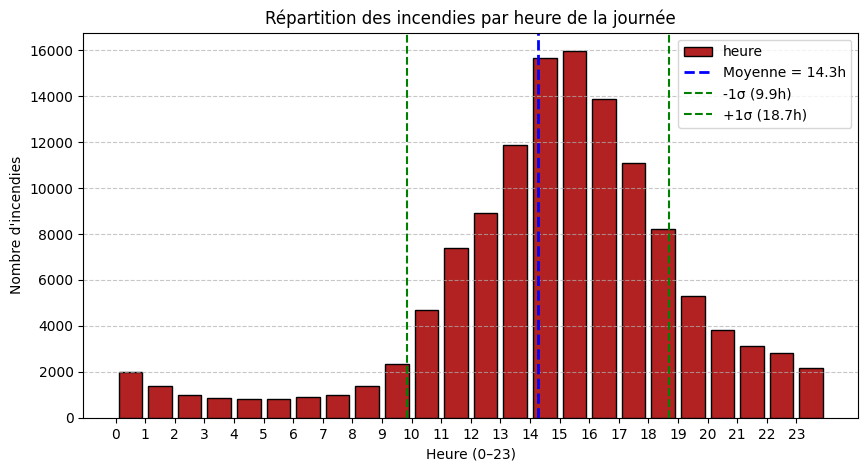

In [276]:
# Statistiques de base
mean_hour = df["heure"].mean()
std_hour = df["heure"].std()

print(f"Moyenne des heures : {mean_hour:.2f}")
print(f"Écart-type des heures : {std_hour:.2f}")

# Histogramme
plt.figure(figsize=(10,5))
df["heure"].plot.hist(
    bins=24, range=(0,24), rwidth=0.8, color="firebrick", edgecolor="black"
)

# Ajouter moyenne et ±1 écart-type
plt.axvline(mean_hour, color="blue", linestyle="--", linewidth=2, label=f"Moyenne = {mean_hour:.1f}h")
plt.axvline(mean_hour - std_hour, color="green", linestyle="--", linewidth=1.5, label=f"-1σ ({mean_hour-std_hour:.1f}h)")
plt.axvline(mean_hour + std_hour, color="green", linestyle="--", linewidth=1.5, label=f"+1σ ({mean_hour+std_hour:.1f}h)")

plt.title("Répartition des incendies par heure de la journée")
plt.xlabel("Heure (0–23)")
plt.ylabel("Nombre d'incendies")
plt.xticks(range(0,24))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.show()


## 5) Identifier numériques / catégorielles / surfaces

In [277]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

# Colonnes surfaces
surface_cols = [c for c in df.columns if 'surface' in c]
num_cols[:10], cat_cols[:10], surface_cols[:5]


(['numero_incendie',
  'surface_brulee_m2',
  'type_peuplement',
  'latitude',
  'longitude',
  'population_commune',
  'superficie_km2',
  'densite_population',
  'mois',
  'jour'],
 ['annee',
  'code_departement',
  'code_insee',
  'commune_incendie',
  'nature_incendie',
  'commune_ref',
  'type_peuplement_label'],
 ['surface_brulee_m2'])

## 6) Diagnostic qualité — métriques pour décider

In [278]:
def missing_report(dataframe):
    miss = dataframe.isna().sum().sort_values(ascending=False)
    ratio = (dataframe.isna().mean()*100).sort_values(ascending=False)
    return pd.DataFrame({'manquants': miss, 'pourcentage': ratio}).reset_index(names='col')

def duplicate_report(dataframe):
    n_dup = dataframe.duplicated().sum()
    return pd.DataFrame({'doublons':[n_dup], 'pourcentage':[100*n_dup/len(dataframe) if len(dataframe) else 0]})

def outlier_report_iqr(series):
    s = pd.to_numeric(series, errors='coerce').dropna()
    if s.empty:
        return {'q1':np.nan,'q3':np.nan,'iqr':np.nan,'borne_sup':np.nan,'outliers':0,'pct':0.0}
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    borne_sup = q3 + 1.5*iqr
    out = (s > borne_sup).sum()
    return {'q1':q1,'q3':q3,'iqr':iqr,'borne_sup':borne_sup,'outliers':out,'pct':100*out/len(s)}

def category_report(series, top_n=20):
    vc = series.astype('string').fillna('<NA>').value_counts(dropna=False, normalize=True)*100
    return vc.head(top_n).rename('pct').to_frame()

# Rapports
miss_df = missing_report(df)
dup_df  = duplicate_report(df)
miss_df.head(15), dup_df


(                   col  manquants  pourcentage
 0                annee          0          0.0
 1      numero_incendie          0          0.0
 2     code_departement          0          0.0
 3           code_insee          0          0.0
 4     commune_incendie          0          0.0
 5    surface_brulee_m2          0          0.0
 6      type_peuplement          0          0.0
 7      nature_incendie          0          0.0
 8          commune_ref          0          0.0
 9             latitude          0          0.0
 10           longitude          0          0.0
 11  population_commune          0          0.0
 12      superficie_km2          0          0.0
 13  densite_population          0          0.0
 14                mois          0          0.0,
    doublons  pourcentage
 0         0          0.0)

In [279]:
# Rapport d'outliers (IQR) pour les colonnes numériques principales
iqr_rows = []
for c in (surface_cols if surface_cols else num_cols):
    stats = outlier_report_iqr(df[c])
    stats['col'] = c
    iqr_rows.append(stats)
iqr_df = pd.DataFrame(iqr_rows).sort_values('pct', ascending=False)
iqr_df.head(15)


,q1,q3,iqr,borne_sup,outliers,pct,col
0,500.0,12000.0,11500.0,29250.0,19733,15.500935,surface_brulee_m2


> **Interprétation (règles pratiques)**  
- **Valeurs manquantes** :  
  - `< 5%` → imputation simple (0, médiane, mode) acceptable.  
  - `5–30%` → à discuter, imputation prudente.  
  - `> 30%` → envisager de supprimer la colonne **non critique**.  
- **Doublons** :  
  - `< 1%` → suppression OK.  
  - `> 10%` → probable problème amont (ingestion / jointures).  
- **Outliers (IQR)** :  
  - `< 1%` → capping/suppression possible.  
  - `> 5%` → peut refléter des cas extrêmes **réels** (à garder).

## 7) Paramètres & Actions de Nettoyage

In [280]:
# === Paramètres de décision ===
MISSING_DROP_THRESHOLD = 30.0   # % manquants au-delà duquel on drop (si non critique)
OUTLIER_CAP = True              # True = on tronque au seuil IQR
FILL_SURFACES_WITH_ZERO = True  # surfaces NaN → 0
FILL_CATEG_MODE = True          # catégorielles NaN → mode

# === 7.1) Traiter les colonnes de surfaces ===
for c in surface_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')
if FILL_SURFACES_WITH_ZERO and surface_cols:
    df[surface_cols] = df[surface_cols].fillna(0)
    for c in surface_cols:
        df.loc[df[c] < 0, c] = 0  # pas de valeurs négatives logiques

# === 7.2) Imputer certaines catégorielles par le mode ===
if FILL_CATEG_MODE and cat_cols:
    for c in cat_cols:
        mode_val = df[c].mode(dropna=True)
        if len(mode_val):
            df[c] = df[c].fillna(mode_val[0]).astype(str).str.strip().str.lower()

# === 7.3) Supprimer colonnes trop manquantes (non critiques) ===
cols_to_drop = miss_df.loc[miss_df['pourcentage']>MISSING_DROP_THRESHOLD, 'col'].tolist()
# Protéger des colonnes critiques si tu en as (ex: identifiants, dates, codes INSEE)
critical_cols = [date_col] if date_col else []
cols_to_drop = [c for c in cols_to_drop if c not in critical_cols]

df.drop(columns=list(set(cols_to_drop)), inplace=True, errors='ignore')
cols_to_drop


NameError: name 'date_col' is not defined

In [ ]:
# === 7.4) Capping des outliers (IQR) ===
if OUTLIER_CAP:
    for c in (surface_cols if surface_cols else num_cols):
        stats = outlier_report_iqr(df[c])
        if not np.isnan(stats['borne_sup']):
            df.loc[df[c] > stats['borne_sup'], c] = stats['borne_sup']

# === 7.5) Supprimer les doublons ===
n_dup = df.duplicated().sum()
df = df.drop_duplicates()
n_dup


TypeError: '>' not supported between instances of 'str' and 'float'

## 8) Variables dérivées utiles

In [ ]:
# Total des surfaces brûlées
if surface_cols:
    df['surface_totale'] = df[surface_cols].sum(axis=1)
else:
    df['surface_totale'] = np.nan

# Cible binaire : incendie majeur (> 1000 m²)
df['incendie_majeur'] = (df['surface_totale'] > 1000).astype(int)

# Saisonnalité cyclique (si mois dispo)
if 'mois' in df.columns:
    df['sin_mois'] = np.sin(2*np.pi*df['mois']/12)
    df['cos_mois'] = np.cos(2*np.pi*df['mois']/12)

df[['surface_totale','incendie_majeur']].head(5)


## 9) EDA — Explorations rapides

In [ ]:
# 9.1) Nombre d'incendies par année
if 'annee' in df.columns:
    fires_per_year = df.groupby('annee').size()
    ax = fires_per_year.plot(marker='o')
    ax.set_title("Nombre d'incendies par année")
    ax.set_xlabel("Année")
    ax.set_ylabel("Nombre")
    ax.grid(True)
    plt.show()

# 9.2) Distribution des surfaces totales (log)
if 'surface_totale' in df.columns:
    ax = df['surface_totale'].plot(kind='hist', bins=60, log=True)
    ax.set_title("Distribution des surfaces totales (log)")
    ax.set_xlabel("Surface (m²)")
    plt.show()


In [ ]:
# 9.3) Top départements (si colonne dispo)
dept_col_candidates = [c for c in df.columns if c in ['departement','code_departement','dept','code_dept']]
if dept_col_candidates:
    dcol = dept_col_candidates[0]
    top_dept = df[dcol].astype(str).value_counts().head(15)
    ax = top_dept.plot(kind='bar')
    ax.set_title(f"Top départements par nombre d'enregistrements ({dcol})")
    ax.set_ylabel("Nombre")
    plt.xticks(rotation=45)
    plt.show()


## 10) Modélisation — Baseline Random Forest (classification)

In [ ]:
# === Features ===
feature_cols = []
if surface_cols:
    feature_cols += surface_cols
for c in ['annee','mois','sin_mois','cos_mois']:
    if c in df.columns:
        feature_cols.append(c)

# Sélection et nettoyage final
X = df[feature_cols].copy().fillna(0)
y = df['incendie_majeur'].copy() if 'incendie_majeur' in df.columns else None

X.shape, y.value_counts(normalize=True) if y is not None else "Pas de cible"


In [ ]:
# Split train/test (stratifié si possible)
if y is not None and y.nunique() == 2 and len(X) > 0:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    rf = RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:,1] if hasattr(rf, 'predict_proba') else None

    print("=== Rapport de classification ===")
    print(classification_report(y_test, y_pred))

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    print("Matrice de confusion:\n", cm)

    # ROC-AUC si proba dispo
    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba)
        print(f"ROC-AUC: {auc:.3f}")
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.show()

    # Importances
    imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    display(imp.head(15))
    ax = imp.head(20).sort_values().plot(kind='barh')
    ax.set_title("Top importances — RandomForest")
    plt.show()
else:
    print("Cible indisponible ou données insuffisantes pour l'apprentissage.")


## 11) Pistes d'amélioration
- **Validation géographique** : entraîner sur des départements et tester sur d’autres.
- **Enrichissement** : ajouter météo (vent, température, sécheresse), végétation (Corine Land Cover), altitude.
- **Modèles** : Gradient Boosting (XGBoost/LightGBM), calibration des probabilités, courbe PR.
- **Clustering spatio-temporel** : DBSCAN/HDBSCAN pour hotspots + saisonnalité (features cycliques plus fines).
- **App Streamlit** : deux onglets *Historique* et *Prédiction* pour une démonstration end‑to‑end.
